# test_eqt_preprocesses.ipynb
***auth*:  Nathan T. Stevens**  
***org*:   Pacific Northwest Seismic Network (PNSN)**  
***email*: ntsteven@uw.edu**  

***purpose***  

This notebook is used as an intermediate development step for scripts running an intercomparison of pre-processing and instrument-type influences on machine learning (ML) based earthquake detection and phase arrival time picking/classification using the EarthQuake Transformer (`EQTransformer` / EQT) algorithm of Mousavi et al. (2020), its original model weights trained on the `STEAD` data set (Mousavi et al., 2019), and model weights trained on the AI-ready Pacific Northwest Dataset (PNW Store) of Ni et al. (2023).  

We apply in-house data preparation codes documented in this repository `PNSN/Sci-Prod-ML` to curate data collections directly from the ANSS comprehensive catalog (ComCat) and cataloged waveforms accessed via the FDSN using `ObsPy`. Prediction routines are conducted using `SeisBench` (Woollam et al., 2022).

For PSNS purposes, our goals are to constrain the trade-off in pre-processing complexity (called `generator pipelines` in ML jargon) for introduction to EQT, training model selection, and instrument type. This stems from the question of if we can better leverage accelerometer data that are currently not considered in PNSN Earthworm-facilitated automated detection and picking pipelines to improve event localization from stations in high-noise settings (i.e., urban centers). 

## Potential pre-processing elements to test
Presently, data coming from 6C stations like UW.GNW is sampled at 40 Hz for BH? channels and 100 Hz for EN? channels. Compared to the standard 100 Hz resampled data archive provided by Ni and others (2023, Seismica).

 + **Response Removal/Velocity Seismogram Processing**:
    1. Does deconvolving instrument response to get velocity traces from accelerometers improve performance?
    **NOTE**: Using IRIS-DMC sourced instrument response files for decon requires response removal to occur ***before*** resampling
 + **Resample** to:
    1. Native (don't resample) - requires a longer data-stream to hit 6000 samples
    2. 100 Hz - Match training data of Ni and others (2023)
    3. 200 Hz - see if we can get away with less data? (i.e., shorter data packets)
 + **Filter** with:
    1. Downsampling of *EN?* data requires a 40 Hz lowpass filter
    2. What other filtering might be relevant? What does SeisBench do, if anything?

    
**Notes on preprocessing of `BH?` data in Ni et al. (2023)**  

> *We first curate waveforms fromhigh-gain velocity seismometers and specific channelsfrom short-period (EH?) and broad-band (either BH?or HH?) seismometers.  We do not use the SL? andSH? channels since they are simply derived from EH?channel after low-pass filtering or down-sampling. Wealso include waveforms from strong-motion EN? sta-tions separately since there are also picks made on thesechannels by the analysts. We do not correct for instru-mental response and do not integrate the accelerationto velocity. All waveforms are resampled to 100 Hz fromtheir original sampling rates, which may be 40 (mostBH? channels) or 100 (most EH? and HH? channels).*

- Ni et al. (2023, Seismica) pg. 4: Data Selection & Preparation --> Waveform Events 



**References**  

Mousavi, S. M., Sheng, Y., Zhu, W., and Beroza, G. C.  STanfordEArthquakeDataset(STEAD):Aglobaldatasetofseismic signalsfor AI.IEEE Access, 7:179464–179476, 2019. doi:10.1109/AC-CESS.2019.2947848.

Mousavi, S. M., Ellsworth, W. L., Zhu, W., Chuang, L. Y., andBeroza, G. C.   Earthquake transformer—an attentive deep-learning model for simultaneous earthquake detection andphase picking.Nature communications, 11(1):1–12, 2020. doi:10.1038/s41467-020-17591-w.

Ni, Yiyu, Alexander Hutko, Francesca Skene, Marine Denolle, Stephen Malone, Paul Bodin, Renate Hartog, and Amy Wright. “Curated Pacific Northwest AI-Ready Seismic Dataset.” Seismica 2, no. 1 (May 8, 2023). https://doi.org/10.26443/seismica.v2i1.368.

Woollam, J., Münchmeyer, J., Tilmann, F., Rietbrock, A., Lange, D.,Bornstein, T., Diehl, T., Giunchi, C., Haslinger, F., Jozinović, D.,et al. SeisBench—A toolbox for machine learning in seismology.Seismological Society of America, 93(3):1695–1709, 2022. doi:10.1785/0220210324.


**Data Sources**  
University of Washington.  Pacific Northwest Seismic Network- University of Washington, 1963.https://www.fdsn.org/networks/detail/UW/.

Ni, Y. niyiyu/PNW-ML: PNW-ML Seismic Dataset. doi:10.5281/zen-odo.7627103.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from datetime import datetime
from obspy import UTCDateTime, Stream
from seisbench.models import EQTransformer, WaveformModel
sys.path.append(os.path.join('..','..'))
import query.verboseevent as qve
from util.preprocess import split_streams, order_traces
from util.translate import relabel_annotations
import matplotlib.pyplot as plt
import pickle
%matplotlib widget

In [2]:
# Document numpy random seed
rng = np.random.default_rng(62323)

In [3]:
# Instantiate the EQTransformer model(s)
model_pnw = EQTransformer.from_pretrained('pnw')
model_pnw_nf = EQTransformer.from_pretrained('pnw')
model_pnw_nf.filter_args = None
model_pnw_nf.filter_kwargs = None
model_ste = EQTransformer.from_pretrained('stead')
# Create dictionary keyed with training data codes
mod_dict = {'D': model_ste, 'W': model_pnw, 'X': model_pnw_nf}
# mod_dict = {'X': model_pnw_nf,'W': model_pnw}

In [4]:
# Import ML picks from Ni et al. (2023)
flist = glob(os.path.join('.','data','Ni_etal_2023_ml_picks','*','UW.GNW*'))
flist.sort()

ml_marks = []
catch_list = []
for f_ in flist:
    with open(f_,'rb') as _f_:
        _p = pickle.load(_f_)
    for __p in _p:
        line = [__p.trace_id, __p.phase,
                pd.Timestamp(__p.start_time.isoformat()),
                pd.Timestamp(__p.peak_time.isoformat()),
                __p.peak_value,
                pd.Timestamp(__p.end_time.isoformat())]
        if line not in ml_marks:
            ml_marks.append(line)
        else:
            catch_list.append(line)

df_ml = pd.DataFrame(ml_marks,columns=['trace_id', 'phase',
                                       'start_time', 'peak_time',
                                       'peak_value','end_time'])
display(df_ml)


,trace_id,phase,start_time,peak_time,peak_value,end_time
0,UW.GNW.,P,2017-05-10 00:33:25.695,2017-05-10 00:33:25.735,0.113565,2017-05-10 00:33:25.905
1,UW.GNW.,P,2017-05-10 00:51:51.895,2017-05-10 00:51:51.935,0.116006,2017-05-10 00:51:52.255
2,UW.GNW.,S,2017-05-10 00:51:57.975,2017-05-10 00:51:58.075,0.109111,2017-05-10 00:51:58.345
3,UW.GNW.,P,2017-05-10 01:05:20.255,2017-05-10 01:05:20.255,0.101485,2017-05-10 01:05:20.455
4,UW.GNW.,P,2017-05-10 01:15:31.615,2017-05-10 01:15:31.655,0.124897,2017-05-10 01:15:31.865
...,...,...,...,...,...,...
1135,UW.GNW.,P,2017-05-20 16:58:52.485,2017-05-20 16:58:52.625,0.143280,2017-05-20 16:58:53.025
1136,UW.GNW.,P,2017-05-20 17:19:29.175,2017-05-20 17:19:29.215,0.104341,2017-05-20 17:19:29.375
1137,UW.GNW.,P,2017-05-20 19:28:32.335,2017-05-20 19:28:32.535,0.219855,2017-05-20 19:28:32.785
1138,UW.GNW.,S,2017-05-20 19:28:38.475,2017-05-20 19:28:38.545,0.102964,2017-05-20 19:28:38.735


In [5]:
# Load (random) Event Data
event_archives = glob(os.path.join('.','data','uw*'))
event_archives.sort()

ei = 22 # This gets the Ml 3.5 main-shock from the sorted list of ComCat events
# RANDOMLY SELECT AN EVENT!
ei = int(np.random.uniform(low=0, high=len(event_archives), size=(1,))//1)
print(f'!!!! RANDOM INDEX IS {ei} !!!!')


ve = qve.VerboseEvent()
ve.from_layered_directory(event_archives[ei])
display(ve)

IND = (df_ml['peak_time'] >= pd.Timestamp(ve.waveforms[0].stats.starttime.isoformat())) &\
      (df_ml['peak_time'] <= pd.Timestamp(ve.waveforms[0].stats.endtime.isoformat()))
idf_ml = df_ml[IND]
display(idf_ml)

# ve_list = []
# for f_ in tqdm(event_archives):
#     _ve = qve.VerboseEvent()
#     _ve.from_layered_directory(f_)
#     ve_list.append(_ve)

# vcat = qve.VerboseCatalog(verbose_catalog_list=ve_list)

# # Get indices for 5 highes magnitude events
# eve_inds = vcat.summary.sort_values('Magnitude', ascending=False).index[:5]# Subset to the largest event
# # but maintain syntax that will be easy to wrap subsequent steps in a `for` loop
# ei = eve_inds[0]
# # RANDOMLY SELECT AN EVENT!
# ve = vcat.events[_ei]


/var/folders/9_/bj6tpb_93rd3b2tr7466ztqr0000gn/T/ipykernel_20384/1220500298.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ei = int(np.random.uniform(low=0, high=len(event_archives), size=(1,))//1)


!!!! RANDOM INDEX IS 56 !!!!


=== event ===
uw61268002 2017-05-20 07:49:37.990000 (47.555,-122.781) 17.6 km M0.5
=== history ===
None
=== phase ===
        Channel  Distance  Azimuth Phase            Arrival Time  Status  \
0   UW.GMW.EHZ.  0.008476    210.8     P 2017-05-20 07:49:40.870  manual   
1   UW.GNW.BHE.  0.031050    287.2     S 2017-05-20 07:49:42.860  manual   
2   UW.HDW.EHZ.  0.207800    296.9     P 2017-05-20 07:49:42.560  manual   
3   UW.HDW.EHZ.  0.207800    296.9     S 2017-05-20 07:49:46.030  manual   
4   UW.GNW.BHZ.  0.031050    287.2     P 2017-05-20 07:49:40.670  manual   
5  UW.DOSE.BHE.  0.207300    321.7     S 2017-05-20 07:49:45.770  manual   
6  PB.B013.EH2.  0.272600    341.4     S 2017-05-20 07:49:47.520  manual   

   Residual  Weight Agency  
0      0.00    0.12     UW  
1      0.00    0.12     UW  
2      0.04    0.09     UW  
3     -0.02    0.09     UW  
4     -0.05    0.09     UW  
5     -0.50    0.00     UW  
6     -0.01    0.09     UW  
=== waveforms ===
6 Trace(s) in Stream:
U

,trace_id,phase,start_time,peak_time,peak_value,end_time
1106,UW.GNW.,P,2017-05-20 07:48:05.585,2017-05-20 07:48:05.875,0.701519,2017-05-20 07:48:06.295
1107,UW.GNW.,S,2017-05-20 07:48:07.755,2017-05-20 07:48:07.985,0.487954,2017-05-20 07:48:08.225
1108,UW.GNW.,P,2017-05-20 07:49:40.495,2017-05-20 07:49:40.775,0.723379,2017-05-20 07:49:41.135
1109,UW.GNW.,S,2017-05-20 07:49:42.625,2017-05-20 07:49:42.835,0.553940,2017-05-20 07:49:43.135


In [6]:
IND = (df_ml['peak_time'] >= pd.Timestamp(ve.waveforms[0].stats.starttime.isoformat())) &\
      (df_ml['peak_time'] <= pd.Timestamp(ve.waveforms[0].stats.endtime.isoformat()))
idf_ml = df_ml[IND]
display(idf_ml)

,trace_id,phase,start_time,peak_time,peak_value,end_time
1106,UW.GNW.,P,2017-05-20 07:48:05.585,2017-05-20 07:48:05.875,0.701519,2017-05-20 07:48:06.295
1107,UW.GNW.,S,2017-05-20 07:48:07.755,2017-05-20 07:48:07.985,0.487954,2017-05-20 07:48:08.225
1108,UW.GNW.,P,2017-05-20 07:49:40.495,2017-05-20 07:49:40.775,0.723379,2017-05-20 07:49:41.135
1109,UW.GNW.,S,2017-05-20 07:49:42.625,2017-05-20 07:49:42.835,0.553940,2017-05-20 07:49:43.135


## Experiement 1: Recreating results from Ni et al. (2023) on broadband recordings
I) **What are the effects of just resampling data?**  
II) **Can we reproduce picks using the methods and data from Ni et al. (2023)?**  
III) **How does the PNW trained model compare to the STEAD trained model?** . 

... the detection threshold set by Ni et al. (2023)

> The input size of the Earthquake Transformer using SeisBench is 3-component, 60 seconds at 100 Hz. The probability threshold for picking is 10%. Figure 4 shows the distributions of the residuals among models and for both P and S wave picks.

- Ni et al. (2023); pg. 7: Machine Learning Picker and Enhanced Earthquake Picks

Processing steps:  
 1. Resample data to 40 Hz, 100 Hz, and 200 Hz using `stream.resample` to capture sampling rates common to sensors for 2017 PNSN  
 2. Run independent `EQTransformer` predictions on resampled data, using both the STEAD and PNW trained models  
 3. Compare results graphically

In [7]:
# 1 - Resample data
# Divide streams by instrument type
streams = split_streams(ve.waveforms)
#
st040 = streams['BH'].copy().normalize()
# Resample data to 100 Hz, no instrument correction, no filtering
st100 = st040.copy().resample(100).normalize()

# Resample data to 200 Hz
st200 = st040.copy().resample(200).normalize()

display(st040)
display(st100)
display(st200)

3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.505000Z | 40.0 Hz, 12381 samples
UW.GNW..BHN | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.505000Z | 40.0 Hz, 12381 samples
UW.GNW..BHE | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.505000Z | 40.0 Hz, 12381 samples

3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.515000Z | 100.0 Hz, 30952 samples
UW.GNW..BHN | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.515000Z | 100.0 Hz, 30952 samples
UW.GNW..BHE | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.515000Z | 100.0 Hz, 30952 samples

3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.525000Z | 200.0 Hz, 61905 samples
UW.GNW..BHN | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.525000Z | 200.0 Hz, 61905 samples
UW.GNW..BHE | 2017-05-20T07:47:08.005000Z - 2017-05-20T07:52:17.525000Z | 200.0 Hz, 61905 samples

In [8]:
# 2 - Conduct Predictions on resampled data using the PNW and STEAD trained models
mod_dict['W'].sampling_rate = 40
BH040_W_ann = mod_dict['W'].annotate(st040)
mod_dict['D'].sampling_rate = 40
BH040_D_ann = mod_dict['D'].annotate(st040)
mod_dict['X'].sampling_rate = 40
BH040_X_ann = mod_dict['X'].annotate(st040)
mod_dict['W'].sampling_rate = 100
BH100_W_ann = mod_dict['W'].annotate(st100)
mod_dict['D'].sampling_rate = 100
BH100_D_ann = mod_dict['D'].annotate(st100)
mod_dict['X'].sampling_rate = 100
BH100_X_ann = mod_dict['X'].annotate(st100)
mod_dict['W'].sampling_rate = 200
BH200_W_ann = mod_dict['W'].annotate(st200)
mod_dict['D'].sampling_rate = 200
BH200_D_ann = mod_dict['D'].annotate(st200)
mod_dict['X'].sampling_rate = 200
BH200_X_ann = mod_dict['X'].annotate(st200)

# Return models to 100 sps default
for _key in mod_dict.keys():
    mod_dict[_key].sampling_rate = 100

/Users/nates/miniforge3/envs/pnsn_ml_dev_apple/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


/Users/nates/miniforge3/envs/pnsn_ml_dev_apple/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


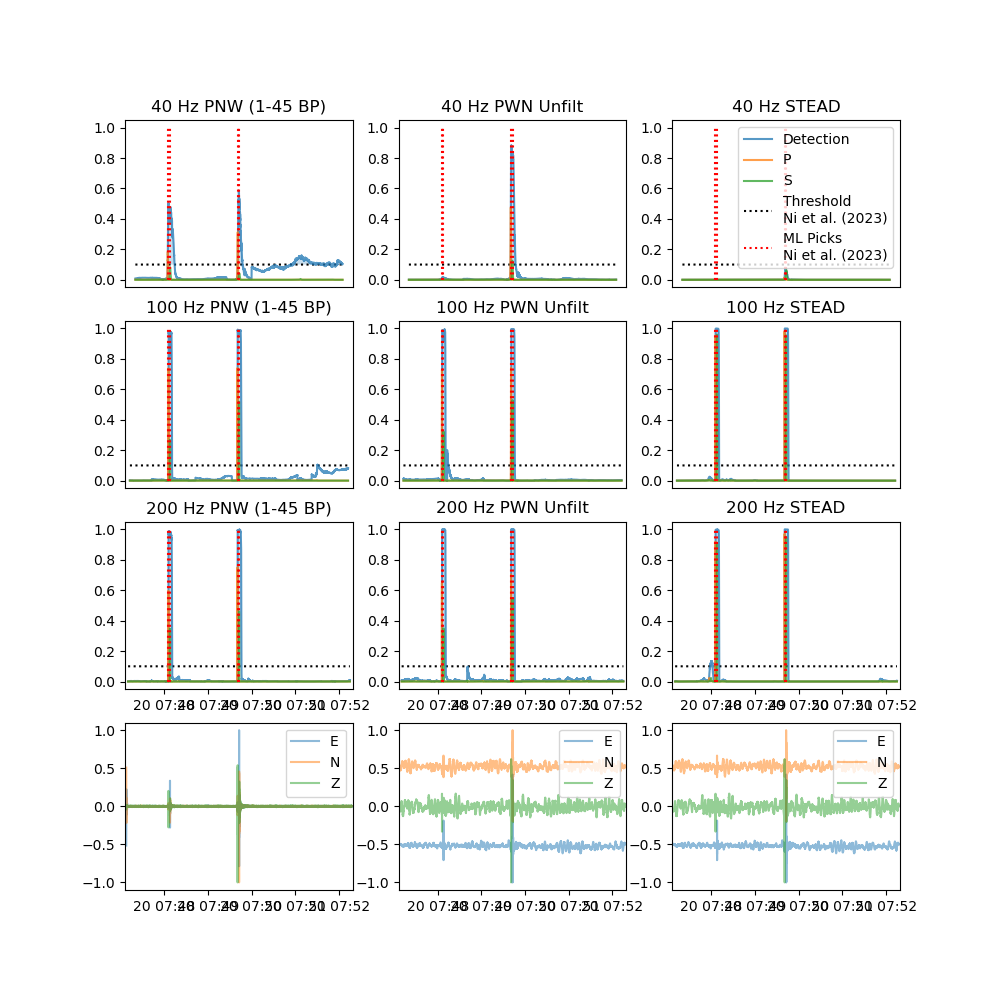

In [9]:
# 3 - Create interactive plot for exploring data and predictions
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(ncols=3,nrows=4)
## Some hinky formatting tricks to have windows scale together
# Create seed axis object
ax1 = fig.add_subplot(gs[0])
# Have all prediction axes share x and y scaling, use list comprehension for shorthand
axs = [ax1] + [fig.add_subplot(gs[x],sharex=ax1, sharey=ax1) for x in np.arange(1,9)]
# Have first waveform axis share only x scaling with prediction plots
ax2 = fig.add_subplot(gs[9],sharex=ax1)
# Have second waveform axis share x and y scaling with first waveform axis
ax3 = fig.add_subplot(gs[10],sharex=ax2,sharey=ax2)
ax4 = fig.add_subplot(gs[11],sharex=ax2,sharey=ax2)

# Bundle everything
axs += [ax2, ax3, ax4]
# Define data sources for prediction curves
dats = [BH040_W_ann, BH040_X_ann, BH040_D_ann, BH100_W_ann, BH100_X_ann, BH100_D_ann, BH200_W_ann, BH200_X_ann, BH200_D_ann]
for _i, _ax in enumerate(axs):
    if _i < len(dats):
        _dat = dats[_i]
        # Plot predction curves
        for _tr in _dat:
            # _ax.fill_between(_tr.times(), [0.1]*_tr.stats.npts, _tr.data, alpha=0.25)
            _ax.plot(_tr.times(type='matplotlib'), _tr.data, alpha=0.75, label=_tr.stats.channel.split('_')[-1])
            _ax.fill_between(_tr.times(type='matplotlib'), [0.1]*_tr.stats.npts, _tr.data, where=_tr.data >= 0.1, alpha=0.25)

        # Format figure labels
        if _i < 3:
            sr = 40
        elif 3 <= _i < 6:
            sr = 100
        elif _i >= 6:
            sr = 200
        if _i in [2,5,8]:
            mo = 'STEAD'
        elif _i in [0,3,6]:
            mo = 'PNW (1-45 BP)'
        elif _i in [1,4,7]:
            mo = 'PWN Unfilt'

        # Plot data from Ni et al. (2023)
        _ax.plot(_tr.times(type='matplotlib'),[0.1]*_tr.stats.npts,'k:',label='Threshold\nNi et al. (2023)',zorder=1)
        xlims = _ax.get_xlim()
        for _j in range(len(idf_ml)):
            if _j == 0:
                _lab = 'ML Picks\nNi et al. (2023)'
            else:
                _lab = None
            _ax.plot([idf_ml['peak_time'].values[_j]]*2,[0,1],'r:',label=_lab)
        _ax.set_xlim(xlims)

        
        # Put legend for prediction curves in 2nd subplot
        if _i == 2:
            _ax.legend()
        _ax.set_title(f'{sr} Hz {mo}')
    # Make waveform figures
    if _i >= len(dats):
        for _j,_c in enumerate(['E','N','Z']):
            if _i == 9:
                _ax.plot(st040[0].times(type='matplotlib'),st040.copy().select(channel=f'??{_c}').filter('bandpass',freqmin=1, freqmax=45).normalize()[0].data,label=_c,alpha=0.5)
            else:
                _ax.plot(st040[0].times(type='matplotlib'),st040.copy().select(channel=f'??{_c}').normalize()[0].data,label=_c,alpha=0.5)

        _ax.legend()

    # Remove annotations on figs 1-6 x-axes to clean up visuals, keep times on figs 7 & 8
    for _i in range(6):
        axs[_i].xaxis.set_visible(False)



### Findings from Experiment  1 (using the Ml 3.5 mainshock for the Bremerton EQ sequence)
1. How does the PNW trained EQTransoformer model behave compared to the STEAD trained model?  
        a. PNW trained model has a much more responsive `Detection` prediction compared to STEAD  
        b. P and S prediction peaks may be suppressed in amplitude compared to STEAD results for larger events 
        c. PNW trained model appears to be more sensitive to small events  

2. How does the sampling rate affect prediction/detection for both models?
        a. Changing the sampling rate by a factor of 2-5 has some impact the amplitudes or morphologies of prediction curves  
        b. Thus the amount of record time required for an input tensor to the ML model (6000, 3) may be reduced to a certain degree with upsampling data  
        c. Upsampling the data resulted in an additional P-detection per the 0.1 threshold (see subplot 5, towards the end of the record)  
        
3. Can we reproduce results from Ni et al. (2023)?  
        a. The 0.1 probability threshold set by Ni et al. (2023) to produce the picks reported (red vertical lines) is not reproduced by our application of their methods.  
        b. It appears that some additional metric that may be the combination of the `Detection` ,`P`, and `S` annotation curves is necessary to recreate their results. Alternatively, it may require a lower threshold to achieve the indicated values.  


**NOTES FOR NEXT STEPS**  
1. Chat with Yiyu on 10/24/23
        a. Needed to normalize traces before running `annotate()`... corrected in code above
        b. Need to specify with each `model` instance what the sampling rate should be ... corrected in code above
        c. Now dependably reproducing Yiyu's results with the 1-45 Hz bandpass prefilterd predictions 
2. Apply corrections to workflows below..., and largely ignore comments in the finding notes above. Keep them for posterity.


# Experiment 2: Compare performance of acceleration and velocity seismograms
**NOTES BEFORE STARTING**: 
1. Data ***MUST*** have instrument responses removed ***BEFORE*** resampling for this dataset, as sampling rate is a factor in the instrument response function.
2. Instrument response deconvolution parameters (i.e., water level values) were determined by minimizing the mean and variances of differences between accelerometer (strong motion, EN? channels) and velocimeter (broadband, BH? channels) that were both converted into `VEL` and `ACC` traces. See `test_instrument_response_correction.py` for experimental methods and results.

**Procedure**
1. Get raw waveforms from the randomly selected event
2. Deconvolve instrument response to make `VEL` and `ACC` traces for both `UW.GNW..BH?` and `UW.GNW..EN?`. 
3. Run predictions using the `PNW` and `STEAD` trained `EQTransformer`
4. Compare visually

**Note**: No resampling conducted in this experiment

In [10]:
# Load (random) Event Data
event_archives = glob(os.path.join('.','data','uw*'))
event_archives.sort()

# ei = 22 # This gets the Ml 3.5 main-shock from the sorted list of ComCat events
# RANDOMLY SELECT AN EVENT!
ei = int(np.random.uniform(low=0, high=len(event_archives) - 1, size=(1,))//1)
print(f'!!!! RANDOM INDEX IS {ei} !!!!')


ve = qve.VerboseEvent()
ve.from_layered_directory(event_archives[ei])
display(ve.event)
# Make a fresh copy of waveform data
st = ve.waveforms.copy()
# Divide by instrument type
streams = split_streams(st)
display(streams)

IND = (df_ml['peak_time'] >= pd.Timestamp(st[0].stats.starttime.isoformat())) &\
      (df_ml['peak_time'] <= pd.Timestamp(st[0].stats.endtime.isoformat()))
idf_ml = df_ml[IND]
display(idf_ml)

/var/folders/9_/bj6tpb_93rd3b2tr7466ztqr0000gn/T/ipykernel_20384/3981838546.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ei = int(np.random.uniform(low=0, high=len(event_archives) - 1, size=(1,))//1)


!!!! RANDOM INDEX IS 35 !!!!


uw61265312 2017-05-11 22:04:52.420000 (47.620,-122.531) 17.4 km M1.5

{'BH': 3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHN | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHE | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples,
 'EN': 3 Trace(s) in Stream:
UW.GNW..ENZ | 2017-05-11T22:02:22.425000Z - 2017-05-11T22:07:44.845000Z | 100.0 Hz, 32243 samples
UW.GNW..ENN | 2017-05-11T22:02:22.425000Z - 2017-05-11T22:07:44.845000Z | 100.0 Hz, 32243 samples
UW.GNW..ENE | 2017-05-11T22:02:22.425000Z - 2017-05-11T22:07:44.845000Z | 100.0 Hz, 32243 samples}

,trace_id,phase,start_time,peak_time,peak_value,end_time
532,UW.GNW.,P,2017-05-11 22:02:52.365,2017-05-11 22:02:52.665,0.430384,2017-05-11 22:02:53.285
533,UW.GNW.,S,2017-05-11 22:02:56.115,2017-05-11 22:02:56.345,0.379897,2017-05-11 22:02:56.585
534,UW.GNW.,P,2017-05-11 22:04:56.675,2017-05-11 22:04:56.935,0.752968,2017-05-11 22:04:57.275
535,UW.GNW.,S,2017-05-11 22:05:00.215,2017-05-11 22:05:00.465,0.556588,2017-05-11 22:05:00.745
536,UW.GNW.,P,2017-05-11 22:05:17.475,2017-05-11 22:05:17.815,0.720064,2017-05-11 22:05:18.145
537,UW.GNW.,S,2017-05-11 22:05:21.045,2017-05-11 22:05:21.265,0.564560,2017-05-11 22:05:21.555


In [11]:
# Conduct instrument response deconvolution
BHV_kwargs = {'inventory': ve.inventory,
              'water_level': 10,
              'output': 'VEL'}
BHA_kwargs = {'inventory': ve.inventory,
              'water_level': 3,
              'output': 'ACC'}

ENV_kwargs = {'inventory': ve.inventory,
              'water_level': 30,
              'output': 'VEL'}
ENA_kwargs = {'inventory': ve.inventory,
              'water_level': 3,
              'output': 'ACC'}

decon_kwargs = {'BHV': BHV_kwargs, 'BHA': BHA_kwargs,
                'ENV': ENV_kwargs, 'ENA': ENA_kwargs}
ird_streams = {'BH':streams['BH'].normalize()}
for _i, _k in enumerate(decon_kwargs.keys()):
    print(f'Processing {_k}')
    _sc = _k[:2]
    _st = streams[_sc].copy()
    ird_stream = Stream()
    for __tr in _st:
        __tr.remove_response(**decon_kwargs[_k]).normalize()
        ird_stream += __tr
    ird_streams.update({_k:ird_stream})
    if _i == 1:
        ird_streams.update({'EN':streams['EN'].normalize()})

display(ird_streams)

Processing BHV
Processing BHA
Processing ENV
Processing ENA


{'BH': 3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHN | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHE | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples,
 'BHV': 3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHN | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHE | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples,
 'BHA': 3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHN | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples
UW.GNW..BHE | 2017-05-11T22:02:22.430000Z - 2017-05-11T22:07:44.830000Z | 40.0 Hz, 12897 samples,
 'EN': 3 Trace(s) in Stream:
UW.GNW

In [12]:
# Conduct predictions
pred_dict = {}
for _m in ['W','X']: #mod_dict.keys():
    for _k in ird_streams.keys():
        _st = ird_streams[_k]
        _mod = mod_dict[_m]
        print(f'Running prediction with {_m} weights, {_k} data')
        _dps_st = _mod.annotate(_st)
        pred_dict.update({_k+_m:_dps_st})

display(pred_dict)

Running prediction with W weights, BH data
Running prediction with W weights, BHV data
Running prediction with W weights, BHA data


/Users/nates/miniforge3/envs/pnsn_ml_dev_apple/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/Users/nates/miniforge3/envs/pnsn_ml_dev_apple/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/Users/nates/miniforge3/envs/pnsn_ml_dev_apple/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (45) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


Running prediction with W weights, EN data
Running prediction with W weights, ENV data
Running prediction with W weights, ENA data
Running prediction with X weights, BH data
Running prediction with X weights, BHV data
Running prediction with X weights, BHA data
Running prediction with X weights, EN data
Running prediction with X weights, ENV data
Running prediction with X weights, ENA data


{'BHW': 3 Trace(s) in Stream:
UW.GNW..EQTransformer_Detection | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples
UW.GNW..EQTransformer_P         | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples
UW.GNW..EQTransformer_S         | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples,
 'BHVW': 3 Trace(s) in Stream:
UW.GNW..EQTransformer_Detection | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples
UW.GNW..EQTransformer_P         | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples
UW.GNW..EQTransformer_S         | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples,
 'BHAW': 3 Trace(s) in Stream:
UW.GNW..EQTransformer_Detection | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07:39.840000Z | 100.0 Hz, 31242 samples
UW.GNW..EQTransformer_P         | 2017-05-11T22:02:27.430000Z - 2017-05-11T22:07

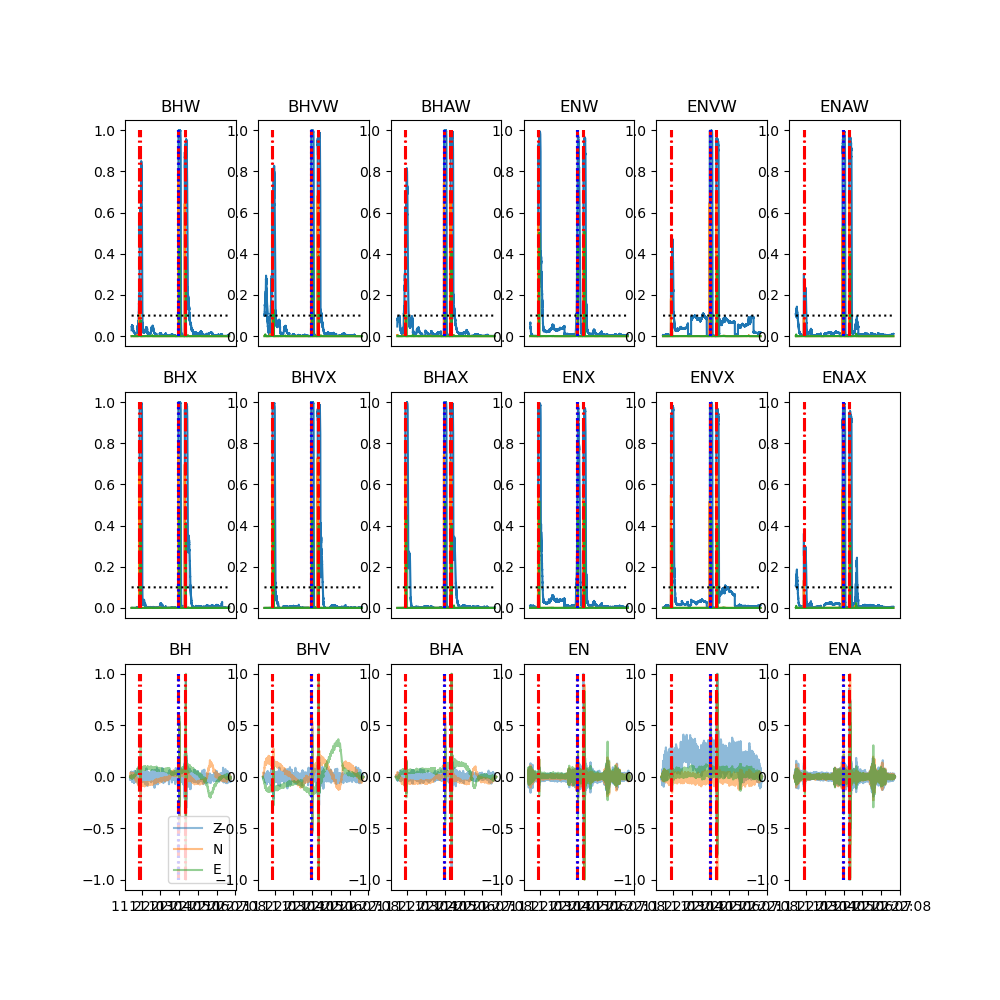

In [13]:
# Visualize
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(ncols=6,nrows=3)
ax1 = fig.add_subplot(gs[0])
axs = [ax1] + [fig.add_subplot(gs[x],sharex=ax1,sharey=ax1) for x in np.arange(1,12)]
ax2 = fig.add_subplot(gs[12],sharex=ax1)
axs3 = [fig.add_subplot(gs[x],sharex=ax2,sharey=ax2) for x in [13,14,15,16,17]]
axs += [ax2] +  axs3


# Plot prediction curves
for _i, _k in enumerate(pred_dict.keys()):
    ax = axs[_i]
    for _tr in pred_dict[_k]:
        ax.plot(_tr.times(type='matplotlib'),_tr.data,label=_tr.stats.channel.split('_')[-1],zorder=1)
        ax.fill_between(_tr.times(type='matplotlib'), [0.1]*_tr.stats.npts, _tr.data, where=_tr.data>0.1,alpha = 0.25)
    ax.set_title(_k)
    ax.xaxis.set_visible(False)

# Plot Ni et al. (2023) threshold 
for _i in range(12):
    axs[_i].plot(_tr.times(type='matplotlib'), [0.1]*_tr.stats.npts,'k:')


# Plot Raw & Instrument Response Deconvolved Streams
for _i, _k in enumerate(ird_streams.keys()):
    ax = axs[_i + 12]
    for _tr in ird_streams[_k]:
        ax.plot(_tr.times(type='matplotlib'),
                _tr.copy().detrend().normalize().data,
                label=_tr.stats.channel[-1],
                alpha=0.5)
    ax.set_title(_k)
    if _i == 0:
        ax.legend()

# Plot ML Picks from Ni et al. (2023)
for _i in range(18):
    ax = axs[_i]
    xlims = ax.get_xlim()
    for _t in idf_ml['peak_time'].values:
        ax.plot([_t]*2,[-1*(_i//12),1],'r-.')
    for _t in ve.phase[ve.phase['Channel'].str.startswith('UW.GNW')]['Arrival Time'].values:
        ax.plot([_t]*2,[-1*(_i//12),1],'b:')
    ax.set_xlim(xlims)


### Findings from Experiment 2

1. In some cases it appears that deconvolving the instrument response from strong motion data enhances the pick probabilities
2. For larger (catalog) events, deconvolving instrument response does not appear to have much of an effect on 
2. Using the STEAD trained EQTransformer continues to have cleaner detection prediction fuctions and higher amplitude P and S pick probabilities compared to PNW trained EQTransformer on larger events
3. PNW trained EQTransformer does a better job of picking low magnitude events

# Experiment 3 - 